# 0. Install Dependencies and Bring in Data

In [7]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [8]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [9]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [10]:
!pip list

Package                      Version
---------------------------- ---------
absl-py                      1.3.0
aiohttp                      3.8.3
aiosignal                    1.2.0
anyio                        3.6.2
asttokens                    2.0.8
astunparse                   1.6.3
async-timeout                4.0.2
attrs                        22.1.0
autopep8                     2.0.0
backcall                     0.2.0
bcrypt                       4.0.1
cachetools                   5.2.0
certifi                      2022.9.24
cffi                         1.15.1
charset-normalizer           2.1.1
click                        8.1.3
colorama                     0.4.6
contourpy                    1.0.5
cryptography                 38.0.1
cycler                       0.11.0
debugpy                      1.6.3
decorator                    5.1.1
entrypoints                  0.4
executing                    1.1.1
fastapi                      0.85.1
ffmpy                        0.3.0
flatbuf


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
from tensorflow.keras.layers import TextVectorization

In [12]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [13]:
# from matplotlib import pyplot as plt
# clms = ['toxic','severe_toxic','obscene',	'threat',	'insult',	'identity_hate']
# # plt.figure(figsize=(8, 5))
# for i in range(0,len(clms)):
#     plt.hist(df[clms[i]], ec="orange", bins=15)
#     plt.title(clms[i])
#     plt.show()

In [14]:
MAX_FEATURES = 200000 # number of words in the vocab

In [15]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [16]:
vectorizer.adapt(X.values)

In [17]:
vectorized_text = vectorizer(X.values)

In [18]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  643,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2506, ...,     0,     0,     0],
       [  425,   440,    70, ...,     0,     0,     0],
       ...,
       [32141,  7329,   383, ...,     0,     0,     0],
       [    5,    12,   533, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>

In [19]:
vectorized_text[1]

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   1,   54, 2506, ...,    0,    0,    0], dtype=int64)>

In [20]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
# pipe lining 16 per batch and 6981 batches
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [21]:
dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 1800), dtype=tf.int64, name=None), TensorSpec(shape=(None, 6), dtype=tf.int64, name=None))>

In [22]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [15]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [16]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam',metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [18]:
history = model.fit(train, epochs=4, validation_data=val)

Epoch 1/4
6981/6981 [==============================] - 5119s 732ms/step - loss: 0.0650 - accuracy: 0.9919 - val_loss: 0.0462 - val_accuracy: 0.9941
Epoch 2/4
6981/6981 [==============================] - 4399s 630ms/step - loss: 0.0471 - accuracy: 0.9938 - val_loss: 0.0424 - val_accuracy: 0.9873
Epoch 3/4
6981/6981 [==============================] - 4394s 629ms/step - loss: 0.0413 - accuracy: 0.9923 - val_loss: 0.0369 - val_accuracy: 0.9946
Epoch 4/4
6981/6981 [==============================] - 4532s 649ms/step - loss: 0.0371 - accuracy: 0.9937 - val_loss: 0.0318 - val_accuracy: 0.9917


In [19]:
import tensorflow as tf
# import gradio as gr
model.save('toxicity.h5')

In [21]:
print("model saved!")

model saved!


<Figure size 800x500 with 0 Axes>

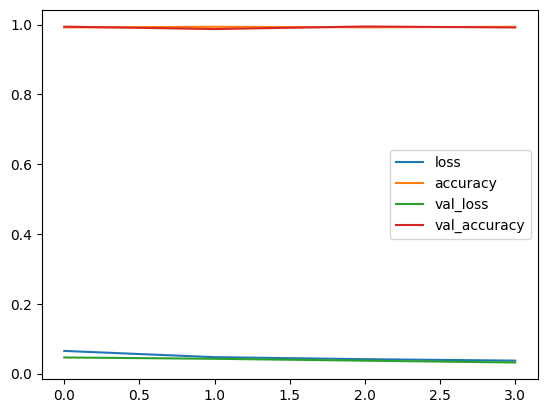

In [22]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [33]:
input_text = vectorizer('Hello,How are you doing')

In [34]:
res = model.predict(np.array([input_text]))


1/1 [==============================] - 0s 125ms/step


In [35]:
# res

In [36]:
(res > 0.5).astype(int)

array([[0, 0, 0, 0, 0, 0]])

In [29]:
test_batch_X, test_batch_y = test.as_numpy_iterator().next()
train_batch_X, train_batch_y = train.as_numpy_iterator().next()

In [30]:
(model.predict(test_batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 395ms/step


array([[0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [31]:
y_pred_train=model.predict(train_batch_X)
y_pred_test=model.predict(test_batch_X)

1/1 [==============================] - 0s 189ms/step


In [32]:
res.shape

(1, 6)

# 5. Test 

In [34]:
train_acc = model.evaluate(train_batch_X, train_batch_y, verbose=0)
test_acc = model.evaluate(test_batch_X, test_batch_y, verbose=0)
acc1=train_acc[1]*100
acc2=test_acc[1]*100

In [35]:
print('Training Accuracy:',acc1,'Testing accuracy:',acc2)

Training Accuracy: 100.0 Testing accuracy: 93.75


In [23]:
import tensorflow as tf
# import gradio as gr

In [24]:
model = tf.keras.models.load_model('toxicity.h5')

In [25]:
input_text = vectorizer('Hey!How are you ding fucker')
res = model.predict(np.array([input_text]))

1/1 [==============================] - 1s 1s/step


In [26]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [27]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [21]:
# model.save('toxicity.h5')